For this demonstration we will be simulating a SrTiO3 CeO2 interface downloaded from https://www.materialscloud.org/explore/stoceriaitf/grid/calculations (slow) or just good ol' silicon (faster). 

In [3]:
import pyms
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

#Get crystal

# crystal = pyms.crystal('Structures/SrTiO3_CeO2_interface.xyz')

# A few maniupulations to remove vaccuum at edges and create a 
# structure psuedo-periodic
# crystal = crystal.slice([0.1,0.76],axis=0)
# crystal = crystal.concatenate_crystals(crystal.slice([0.017,0.99],
#                                     axis=0).reflect([0]),axis=0)

# Output structure for examination in Vesta 
# crystal.output_vesta_xtl('manipulated_SrTiO3_CeO2_interface.xtl')
# tiling = [1,7]

crystal = pyms.crystal('Structures/Si100.xyz',atomic_coordinates='cartesian')
crystal.output_vesta_xtl('Si100.xtl')
tiling = [8,8]
# Quick plot of crystal
# crystal.quickplot(atomscale=1e-2)

# Subslicing of crystal for multislice
nslices = int(np.ceil(crystal.unitcell[2]/2))
subslices = np.linspace(1.0/nslices,1.0,nslices)
nsubslices = len(subslices)

# Set up thickness series
tstep = 100
thicknesses = np.asarray([50,100, 200])

#Grid size in pixels
gridshape = [512,512]

# Probe accelerating voltage in eV
eV = 3e5

# Probe-forming aperture in mrad
app = 15

# Define detector inner and outer angles
# in order, a central bright-field detector, an annular bright-field (ABF)
# detector and a high-angle annular dark-field (HAADF) detector
detectors = [[0,app/2], [app/2,app],[70,150]]

# If only 4D-STEM is requested set detectors to be None
# detectors = None

# Number of frozen phonon passes
# Number typically required for a converged experiment
# nfph = 25
# Number required for a brief run-time
nfph = 5

# 4D-STEM options:

# No 4D-STEM
FourDSTEM = False

# 4D-STEM with diffraction pattern sizing set by
# multislice grid
# FourDSTEM = True

# 4D-STEM with diffraction patterns cropped to
# 128x128 pixel readout
FourDSTEM = [[128,128]]

# 4D-STEM with diffraction patterns cropped to
# 128x128 pixel readout with diffraction space
# dimensions of 3 inverse Angstrom
# FourDSTEM = [[128,128],[3.0,3.0]]

# Probe defocus, an array can be provided for a defocus series
# df = np.arange(-200,300,50)
df = 0

# Option for more control over the device which performs the calculation,
# GPU (CUDA) calculation
device = torch.device('cuda')
# Run calculation on your computer's second GPU
# device = torch.device('cuda:1')
# CPU only calculation
# device = torch.device('cpu')

result = pyms.STEM_multislice(
    gridshape,
    crystal,
    thicknesses,
    eV,
    app,
    subslices=subslices,
    device_type=device,
    df=0,
    nfph=nfph,
    FourD_STEM=FourDSTEM,
    tiling=tiling,
    detector_ranges=detectors,
)


Making projected potentials: 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

Making projected potentials: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

Probe positions:  78%|███████▊  | 45/58 [00:09<00:02,  5.00it/s]


Making projected potentials: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]

Making projected potentials: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]

Probe positions:  55%|█████▌    | 32/58 [00:06<00:05,  5.11it/s]


Making projected potentials: 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]

Frozen phonon iteration: 100%|██████████| 5/5 [01:01<00:00, 12.33s/it]


Now plot STEM images and output datacube into a py4DSTEM (https://github.com/py4dstem/py4DSTEM) friendly format

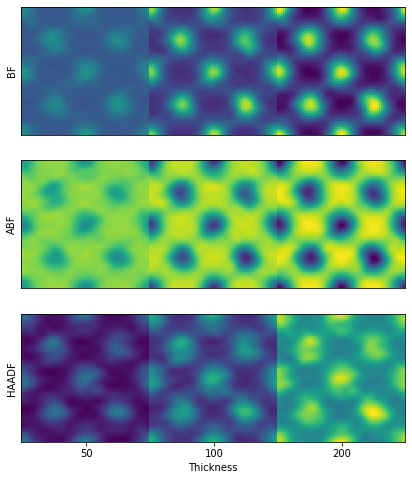

Data-cube written to hdf5 file along with the following metadata:
K_pix_size : 0.02302025782688766
K_pix_units : angstrom^-1
R_pix_size : 0.39134438305709024
R_pix_units : angstrom
R_to_K_rotation_degrees : 0
accelerating_voltage : 300000.0
convergence_semiangle_mrad : 15


In [72]:
# Plot STEM images
if detectors is not None:
    interp_shape = [64,64]
    fig,axes = plt.subplots(figsize=(8,8),nrows = result[0].shape[0])
    interp = pyms.utils.fourier_interpolate_2d(result[0],interp_shape)

    for i,ax in enumerate(axes):
        ax.imshow(np.hstack(interp[i]))
        ax.set_ylabel(['BF','ABF','HAADF'][i])
        ax.set_yticks([])
        ax.set_xticks([])



    ax.set_xticks(np.arange(interp_shape[1]/2,interp_shape[1]*len(thicknesses)+1,interp_shape[1]))
    ax.set_xticklabels(thicknesses)
    ax.set_xlabel('Thickness')
    plt.show()

# Output datacube
if FourDSTEM:
    index = 0
    if detectors is not None: index =1
    sample = crystal.Title
    # Loop over thicknesses (delete loop for a single thickness)
    for i,datacube in enumerate(result[index]):
        filename = '4DSTEM_t={0:03d}'.format(int(thicknesses[i]))
        rsize = crystal.unitcell[:2]*np.asarray(tiling)
        diffsize = np.asarray(result[index].shape[-2:])/rsize
        pyms.utils.datacube_to_py4DSTEM_viewable(datacube,filename,rsize,diffsize,eV,app,sample=sample)
    
    # Demonstration of metadata in hdf5 object
    print('Data-cube written to hdf5 file along with the following metadata:')
    f = h5py.File("4DSTEM_t={0:03d}.h5".format(int(thicknesses[0])),'r')
    for key, value in f['4D-STEM_data/metadata/calibration'].attrs.items():
        print(key,':',value[0])
    f.close()

In [16]:
result[1].shape

(3, 17, 17, 128, 128)

In [65]:
import h5py
f = h5py.File("/home/ncem/4DSTEM_t=050.h5")
for key, value in f['4D-STEM_data/metadata/calibration'].attrs.items():
    print(key,':',value[0])
f.close()

K_pix_size : 0.02302025782688766
K_pix_units : angstrom^-1
R_pix_size : 0.39134438305709024
R_pix_units : angstrom
R_to_K_rotation_degrees : 0
accelerating_voltage : 300000.0
convergence_semiangle_mrad : 15
